In [3]:
PATH_DATAS = 'C:/Users/zfriant/Documents/OneDrive/PCRI/eCorda_datas/'
PATH_REF = f"{PATH_DATAS}datas_reference/"
PATH_CLEAN = f"{PATH_DATAS}datas_clean/"
PATH_WORK='C:/Users/zfriant/Documents/OneDrive/PCRI/eCorda_datas/datas_work/'
FRAMEWORK='HORIZON'

from IPython.display import HTML
import requests, json, os, pandas as pd, datetime as dt, time, urllib3, re, numpy as np, pandas.api.types as pat, copy, openpyxl
requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)

In [4]:
proj = pd.read_pickle(f"{PATH_WORK}projects_all_FW.pkl")
entities = pd.read_pickle(f"{PATH_WORK}entities_participation_current.pkl")

In [5]:
ent = entities.loc[entities.stage=='successful', ['project_id', 'entities_id', 'entities_name', 'erc_role', 'role', 'participates_as', 'operateur_name', 'country_code', 'country_name_fr', 'calculated_fund']].drop_duplicates()

In [6]:
x = proj.loc[proj.framework.isin(['Horizon Europe', 'Horizon 2020']), ['framework', 'project_id','acronym', 'title', 'abstract', 'topic_code', 'topic_name', 'free_keywords']]

In [7]:
y=pd.DataFrame()

for i in ['title', 'abstract', 'topic_name', 'free_keywords']:
         
    x[f'{i}2'] = x[i].str.replace(r" \(.*\)","", regex=True).str.lower()  
    y = pd.concat([y, x.loc[x[f'{i}2'].str.contains('artificial intelligence|machine learning|neural network|deep learning|image processing|natural language processing', na=False)]], ignore_index=True)

In [8]:
len(y) #1903
# y.loc[y.topic_code=='JTI-CS2-2014-CFP01-SYS-02-06']

4920

In [9]:
# scanr = pd.read_json(open(f"{PATH_WORK}grants_ia.jsonl", 'r', encoding='utf-8'), lines=True)
# scanr=scanr[scanr.type=='europe']
# print(len(scanr)) #1138
# scanr

# sc = proj.merge(scanr, how='inner', left_on='project_id', right_on='id')[ ['framework', 'project_id','acronym', 'title', 'abstract', 'topic_code', 'topic_name', 'free_keywords']]
# sc = sc.loc[sc.framework!='FP7']
# # print(len(sc)) #1045
# sc
# HTML(sc.to_html())

In [ ]:
len(x)

In [10]:
p=y.merge(ent, how ='inner', on='project_id').drop_duplicates()

In [11]:
p_erc=p.loc[(p.topic_code.str.contains('ERC-'))&(p.country_code=='FRA'), ['framework', 'project_id','acronym', 'title', 'abstract', 'topic_code', 'topic_name', 'entities_id', 'entities_name', 'operateur_name', 'erc_role' , 'calculated_fund']]
# p_erc.to_csv(f"{PATH_CLEAN}ia_erc.csv", sep=';', na_rep='')

In [12]:
p_ia=p.loc[(~p.topic_code.str.contains('ERC-'))&(p.country_code=='FRA'), ['framework', 'project_id','acronym', 'title', 'abstract', 'topic_code', 'topic_name', 'entities_id', 'entities_name', 'operateur_name', 'calculated_fund']]
# p_ia.to_csv(f"{PATH_CLEAN}ia_tout_prog.csv", sep=';', na_rep='')

In [13]:
fund_tot = p_ia.calculated_fund.sum()
proj_tot = p_ia.project_id.nunique()
p_ia_share = p_ia.groupby(['entities_name', 'entities_id', 'operateur_name']).agg({'calculated_fund':'sum', 'project_id':'nunique'}).reset_index()
p_ia_share['fund_share'] = round(p_ia_share['calculated_fund'] / fund_tot*100, 1)
p_ia_share['proj_share'] = round(p_ia_share['project_id'] / proj_tot*100, 1)
p_ia_share.sort_values('fund_share', ascending=False)

,entities_name,entities_id,operateur_name,calculated_fund,project_id,fund_share,proj_share
15,Commissariat à l’énergie atomique et aux énerg...,zYXK8,Opérateur du programme 172 - Recherches scient...,73635728.29,77,8.5,10.3
11,Centre national de la recherche scientifique,n2X5f,Opérateur du programme 172 - Recherches scient...,67229108.04,141,7.8,18.9
41,Sorbonne Université,bxPQe,Opérateur du programme 150 - Formations supéri...,28219994.62,36,3.3,4.8
25,Institut national de recherche en sciences et ...,E1Wdn,Opérateur du programme 172 - Recherches scient...,25222227.20,47,2.9,6.3
24,Institut national de la santé et de la recherc...,bZiTA,Opérateur du programme 172 - Recherches scient...,17683458.51,29,2.0,3.9
...,...,...,...,...,...,...,...
29,Institut national des sciences appliquées de R...,TeXD3,Opérateur du programme 150 - Formations supéri...,0.00,1,0.0,0.1
60,Université Toulouse Capitole,gap5Q,Opérateur du programme 150 - Formations supéri...,32775.00,2,0.0,0.3
58,Université Sorbonne Paris Nord,cqyN7,Opérateur du programme 150 - Formations supéri...,262875.60,2,0.0,0.3
56,Université Paul-Valéry - Montpellier 3,1I7hJ,Opérateur du programme 150 - Formations supéri...,129375.00,1,0.0,0.1


In [14]:
p_ia_ope=p_ia_share.loc[p_ia_share['operateur_name']=='Opérateur du programme 150 - Formations supérieures et recherche universitaire'].sort_values('fund_share', ascending=False)

In [15]:
import re
def format_label(x):
    current_str=''
    res=[]
    for c in re.split(' |-', x):
        if len(current_str)<15:
            current_str+=c+' '
        else:
            res.append(current_str)
            current_str=c+' '
    res.append(current_str)
    return '\n'.join(res).strip()
            
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
SIZE = 22
SMALL_SIZE=18
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title       

In [16]:
color_dict = {}
color_dict['Université Paris-Saclay'] = '#63003C'
color_dict['Sorbonne Université'] = '#042f66'
color_dict['Université Grenoble Alpes'] = '#FF4E01'
color_dict['Institut polytechnique de Paris'] = 'black'
color_dict['Université Paris sciences et lettres']='#2F3B89'
color_dict['Université de Lorraine'] ='#FFF044'
color_dict['Université de Toulouse'] = '#BE2125'
color_dict['Université de Rennes'] = 'black'
color_dict["Université Côte d'Azur"] = "#007FA5"
color_dict['Université de Strasbourg'] = '#303030'

In [17]:


TOP = 20
top_etab = [{'etab': x, 'label': format_label(x)} for x in p_ia_ope.entities_name.to_list()]
top_shares = p_ia_ope.fund_share.to_list()
top_count = p_ia_ope.project_id.to_list()
top_shares_proj = p_ia_ope.proj_share.to_list()

top_etab_filtered, top_shares_filtered, top_count_filtered = [], [], []
for ix, t in enumerate(top_etab):
    if len(top_etab_filtered) == TOP:
        break
    top_etab_filtered.append(t)
    top_shares_filtered.append(top_shares[ix])
    top_count_filtered.append(top_count[ix])
#     top_shares_proj.append(top_shares_proj[ix])
    
colors = ['grey']*TOP
for ix, etab in enumerate(top_etab_filtered):
    if etab['etab'] in color_dict:
        colors[ix] = color_dict[etab['etab']]

C:\Users\zfriant\AppData\Local\Temp\ipykernel_13660\1436490452.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)


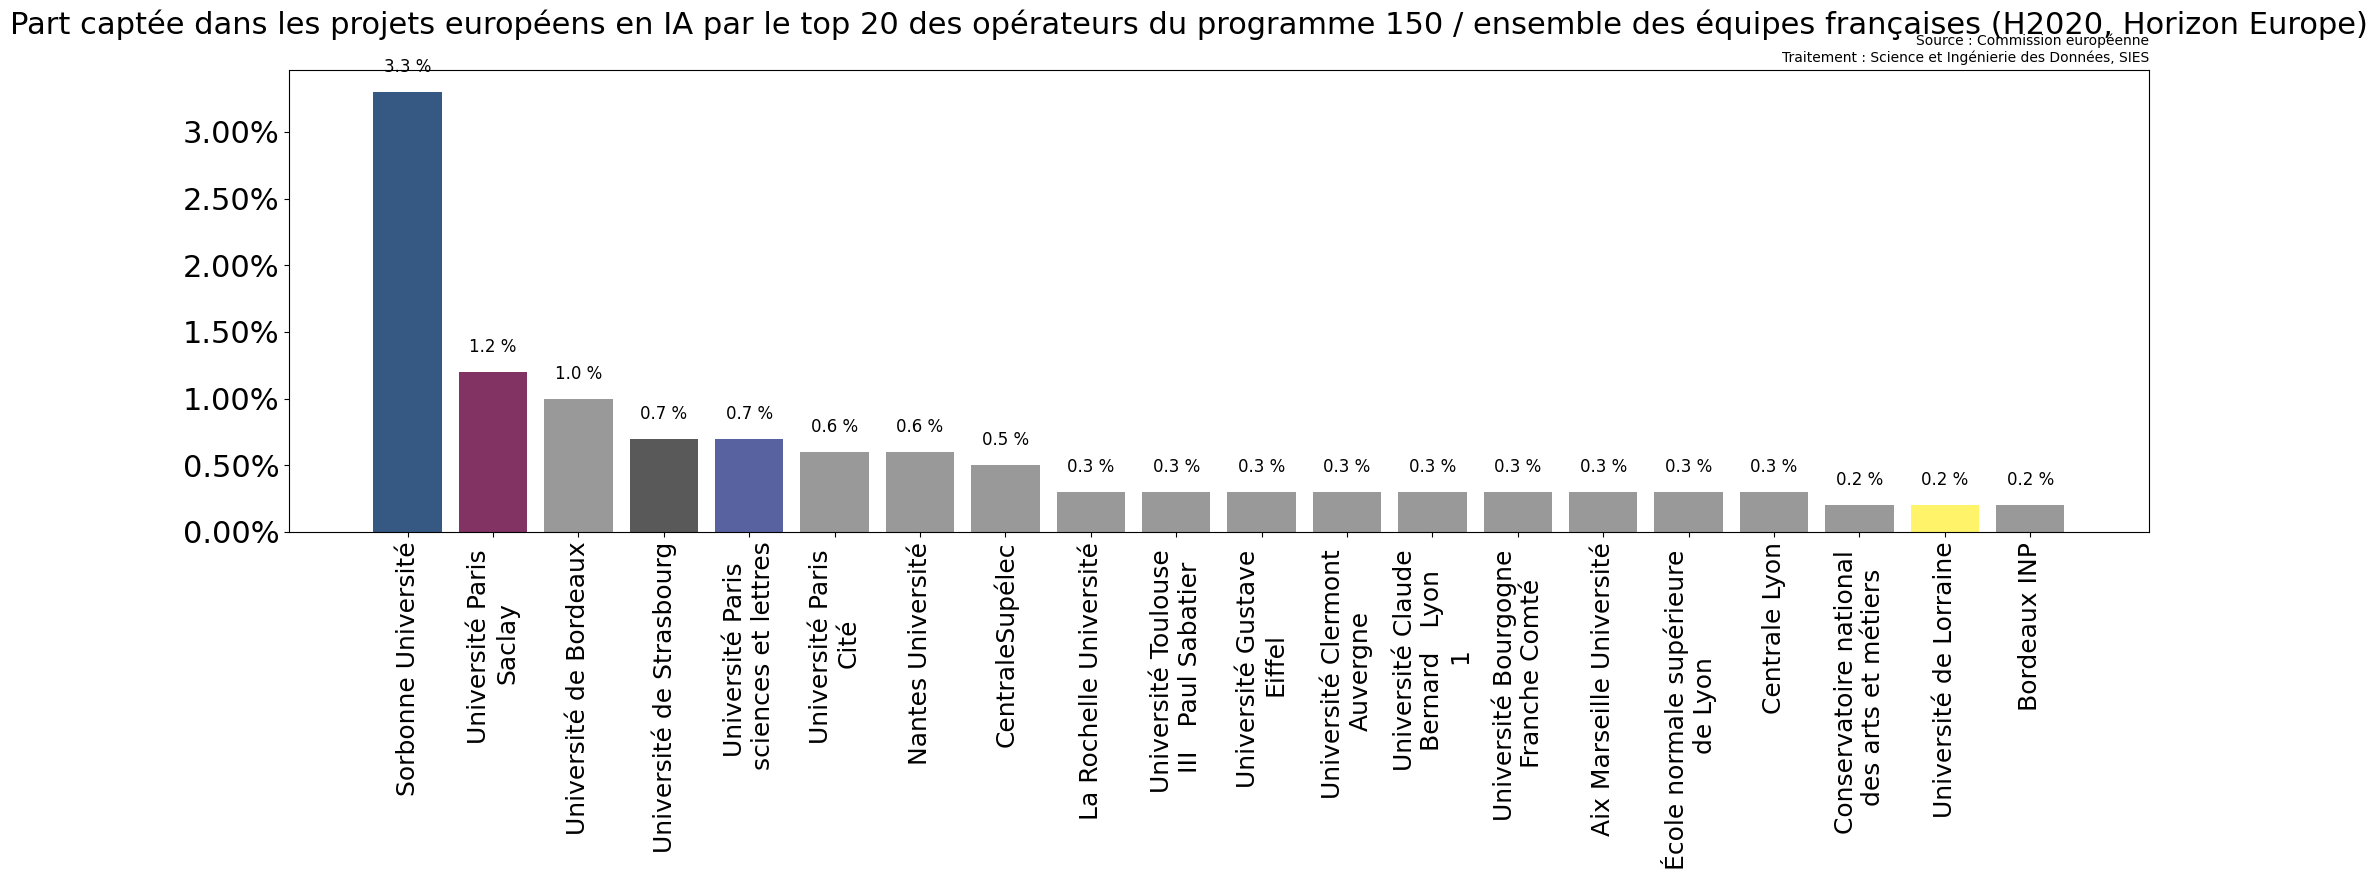

In [18]:
fig, ax = plt.subplots(figsize=(24,6), dpi=100)

ax.bar([e['label'] for e in top_etab_filtered], top_shares_filtered, 
       alpha=0.8, color=colors
      )
plt.suptitle(f"Part captée dans les projets européens en IA par le top 20 des opérateurs du programme 150 / ensemble des équipes françaises (H2020, Horizon Europe)")
plt.title('Source : Commission européenne\nTraitement : Science et Ingénierie des Données, SIES', size=10, loc='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xticklabels([e['label'] for e in top_etab_filtered], rotation='vertical', fontsize=SMALL_SIZE)
for i in range(len(top_etab_filtered)):
    plt.text(i, top_shares_filtered[i]+0.15, str(top_shares_filtered[i])+' %', ha = 'center', fontsize=12)

In [21]:
europe_etab_HE_HEU = pd.DataFrame({'Site': [e['etab'] for e in top_etab_filtered], 
              'Part captée (H2020, Horizon Europe) (%)': top_shares_filtered,
             'Nombre de projets en IA (H2020, Horizon Europe)': top_count_filtered,
           })
europe_etab_HE_HEU.to_csv('europe_etab_HE_HEU.csv', index=False)

In [22]:
europe_etab_HE_HEU

,Site,"Part captée (H2020, Horizon Europe) (%)","Nombre de projets en IA (H2020, Horizon Europe)"
0,Sorbonne Université,3.3,36
1,Université Paris-Saclay,1.2,16
2,Université de Bordeaux,1.0,11
3,Université de Strasbourg,0.7,13
4,Université Paris sciences et lettres,0.7,2
5,Université Paris Cité,0.6,11
6,Nantes Université,0.6,6
7,CentraleSupélec,0.5,8
8,La Rochelle Université,0.3,7
9,Université Toulouse III - Paul Sabatier,0.3,13
